##Self Attention (Scaled dot product attention)


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
"""When text (sentence) is given, it is first broken into tokens,
which are smaller units of the text such as words or subwords"""

sentence = "The quick brown fox jumps over a lazy dog"
word2int = {s: i for i, s in enumerate(sorted(sentence.replace(',', '').split()))}
word2int

{'The': 0,
 'a': 1,
 'brown': 2,
 'dog': 3,
 'fox': 4,
 'jumps': 5,
 'lazy': 6,
 'over': 7,
 'quick': 8}

In [24]:
r = [word2int[i] for i in sentence.replace(',', '').split()]
sentence_int = torch.tensor(r)
sentence_int

tensor([0, 8, 2, 4, 5, 7, 1, 6, 3])

In [25]:
""" Each token is then converted into a vector representation called an embedding"""

vocab_size = 50000  # Assume a large vocabulary size
torch.manual_seed(123)
embed = nn.Embedding(vocab_size, 3)
embedded_sentence = embed(sentence_int).detach()
print(embedded_sentence)
# print(embedded_sentence.shape)

tensor([[ 0.3374, -0.1778, -0.3035],
        [ 0.4965, -1.5723,  0.9666],
        [-0.2196, -0.3792,  0.7671],
        [ 0.1794,  1.8951,  0.4954],
        [ 0.2692, -0.0770, -1.0205],
        [ 1.3010,  1.2753, -0.2010],
        [-0.5880,  0.3486,  0.6603],
        [-0.1690,  0.9178,  1.5810],
        [-1.1925,  0.6984, -1.4097]])


In [26]:
"""From each embedding, the model creates three vectors:
Query(Q): tells the model what this token is "looking for" in other tokens.
Key(K): tells the model what this token has to "offer" to others.
A Value(V): carries the actual information/content of the token."""

torch.manual_seed(123)
d = embedded_sentence.shape[1]  # Dimension of embeddings
d_q, d_k, d_v = 2, 2, 4  # Dimensions for query, key, and value matrices

W_query = torch.nn.Parameter(torch.rand(d, d_q))
W_key = torch.nn.Parameter(torch.rand(d, d_k))
W_value = torch.nn.Parameter(torch.rand(d, d_v))

query = embedded_sentence @ W_query
key = embedded_sentence @ W_key
value = embedded_sentence @ W_value

$\text{attention score}= \frac{(Q K^T)}{\sqrt{d_k}}$

$ \text{attention weights} = \text{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) $

$\text{context value} = \text{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V $


In [27]:
attention_scores = query @ key.T
attention_scores = attention_scores / math.sqrt(d_k)
attention_weights = F.softmax(attention_scores, dim=-1)
attention_weights

tensor([[0.1211, 0.1238, 0.1124, 0.0906, 0.1284, 0.1019, 0.1058, 0.0908, 0.1251],
        [0.1133, 0.1108, 0.1106, 0.1067, 0.1160, 0.1084, 0.1103, 0.1051, 0.1188],
        [0.0972, 0.0936, 0.1066, 0.1411, 0.0904, 0.1210, 0.1157, 0.1400, 0.0944],
        [0.0195, 0.0178, 0.0425, 0.3473, 0.0103, 0.1129, 0.0743, 0.3637, 0.0116],
        [0.1435, 0.1536, 0.1060, 0.0451, 0.1829, 0.0715, 0.0837, 0.0450, 0.1688],
        [0.0311, 0.0299, 0.0582, 0.3047, 0.0185, 0.1264, 0.0896, 0.3223, 0.0195],
        [0.0837, 0.0797, 0.1007, 0.1713, 0.0722, 0.1285, 0.1169, 0.1708, 0.0764],
        [0.0195, 0.0171, 0.0421, 0.3513, 0.0105, 0.1124, 0.0749, 0.3599, 0.0123],
        [0.1524, 0.1661, 0.0874, 0.0191, 0.2395, 0.0432, 0.0580, 0.0186, 0.2158]],
       grad_fn=<SoftmaxBackward0>)

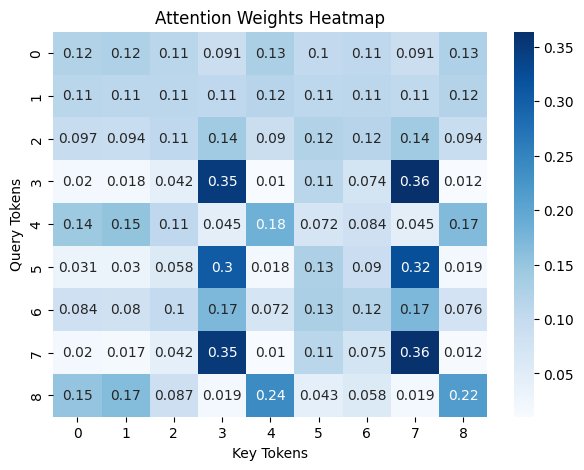

In [28]:
plt.figure(figsize=(7,5))
sns.heatmap(attention_weights.detach().numpy(), annot=True, cmap="Blues")
plt.title("Attention Weights Heatmap")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()

In [29]:
"""we use the attention weights to compute the context vectors"""

context_vector = attention_weights @ value
print(context_vector)

tensor([[ 0.1161,  0.2648,  0.1661,  0.2705],
        [ 0.1610,  0.3502,  0.2213,  0.3606],
        [ 0.2796,  0.5341,  0.3544,  0.5734],
        [ 0.8153,  1.4165,  0.9633,  1.5575],
        [-0.0840, -0.0267, -0.0515, -0.0758],
        [ 0.7347,  1.2733,  0.8703,  1.4049],
        [ 0.3734,  0.6840,  0.4609,  0.7442],
        [ 0.8109,  1.4172,  0.9614,  1.5550],
        [-0.2663, -0.2382, -0.2310, -0.3559]], grad_fn=<MmBackward0>)


In [30]:
class SelfAttention(nn.Module):
  def __init__(self, d, d_q, d_k, d_v):
    super(SelfAttention, self).__init__()
    self.d = d
    self.d_q = d_q
    self.d_k = d_k
    self.d_v = d_v
    self.W_query = nn.Parameter(torch.rand(d, d_q))
    self.W_key = nn.Parameter(torch.rand(d, d_k))
    self.W_value = nn.Parameter(torch.rand(d, d_v))
  def forward(self, x):
    Q = x @ self.W_query
    K = x @ self.W_key
    V = x @ self.W_value
    attention_scores = Q @ K.T / math.sqrt(self.d_k)
    attention_weights = F.softmax(attention_scores, dim=-1)
    context_vector = attention_weights @ V
    return context_vector

sa = SelfAttention(d=3, d_q=2, d_k=2, d_v=4)
cv = sa(embedded_sentence)
print(cv.shape)
print(cv)

torch.Size([9, 4])
tensor([[ 0.1298,  0.0803,  0.1391,  0.2768],
        [ 0.1655,  0.1568,  0.1631,  0.2725],
        [ 0.3061,  0.2906,  0.3173,  0.5926],
        [ 0.7892,  0.7268,  0.8756,  1.8529],
        [-0.1215, -0.2569, -0.1180, -0.1904],
        [ 0.7618,  0.7043,  0.8472,  1.7998],
        [ 0.4224,  0.3984,  0.4465,  0.8663],
        [ 0.7982,  0.7307,  0.8705,  1.7889],
        [-0.3056, -0.5724, -0.3023, -0.5099]], grad_fn=<MmBackward0>)
